In [1]:
using Distributions
using Random
using StatsPlots
default(fmt=:png, titlefontsize=10, plot_titlefontsize=10, tickfontsize=6)

In [2]:
p0, q0 = 0.05, 0.04
m, n = 1000, 1000

Random.seed!(4649373)
x = rand(Binomial(m, p0))
y = rand(Binomial(n, q0))
x, y

(43, 34)

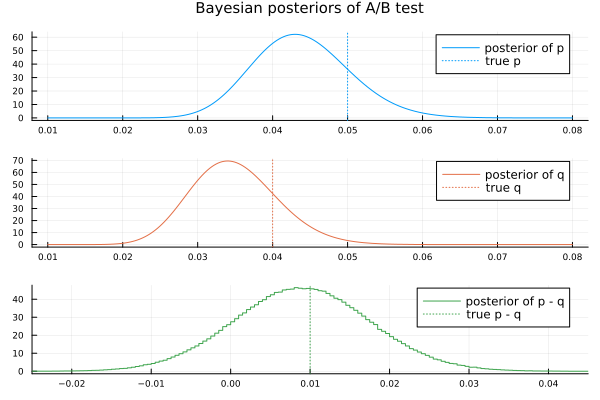

In [3]:
a, b = 1, 1 # flat prior
postx, posty = Beta(x+a, m-x+b), Beta(y+a, n-y+b) # posterior
L = 10^6
p, q = rand(postx, L), rand(posty, L)
delta = p - q

P1 = plot(postx, 0.01, 0.08; c=1, label="posterior of p")
vline!([p0]; label="true p", c=1, ls=:dot)
plot!(xtick=0:0.01:1, ytick=0:10:100)
P2 = plot(posty, 0.01, 0.08; c=2, label="posterior of q")
vline!([q0]; label="true q", c=2, ls=:dot)
plot!(xtick=0:0.01:1, ytick=0:10:100)
P3 = stephist(delta; norm=true, c=3, label="posterior of p - q")
vline!([p0 - q0]; label="true p - q", c=3, ls=:dot)
plot!(xtick=-0.1:0.01:0.1, ytick=0:10:100, xlim=(-0.025, 0.045))

P_bayes = plot(P1, P2, P3; layout=(3, 1))
plot!(plot_title="Bayesian posteriors of A/B test")

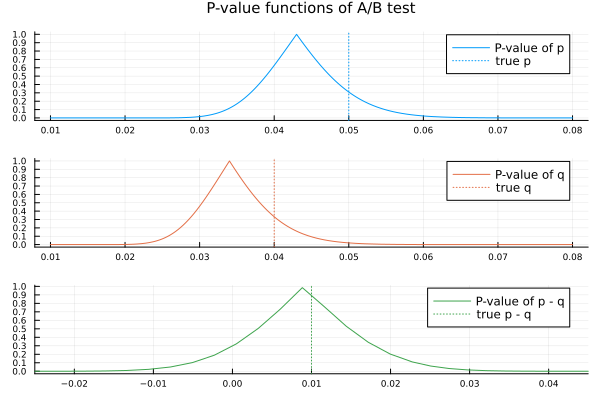

In [4]:
safediv(x, y) = x == 0 ? zero(x/y) : isinf(y) ? zero(x/y) : x/y

function pvalue_wilson(k, n, p)
    p̂ = k/n
    SE = √(p*(1-p)/n)
    2ccdf(Normal(), abs(p̂ - p)/SE)
end

riskdiffhat(a, b, c, d) = safediv(a, a+b) - safediv(c, c+d)

function stderr_riskdiffhat(a, b, c, d; u=0)
    m, n = a+b, c+d
    p̂, q̂ = safediv(a, m), safediv(c, n)
    √(safediv(p̂*(1-p̂), m-u) + safediv(q̂*(1-q̂), n-u))
end

function pvalue_rd_wald(a, b, c, d; Δ=0, u=0)
    RDhat = riskdiffhat(a, b, c, d)
    SEhat_riskdiffhat = stderr_riskdiffhat(a, b, c, d; u)
    2ccdf(Normal(0, 1), safediv(abs(RDhat - Δ), SEhat_riskdiffhat))
end
# This is the Wald version.  For the Zou-Donner version better than it, see
# https://nbviewer.org/github/genkuroki/public/blob/main/0033/probability%20of%20alpha%20error%20of%20Zou-Donner.ipynb

P1 = plot(p -> pvalue_wilson(x, m, p), 0.01, 0.08; c=1, label="P-value of p")
vline!([p0]; label="true p", c=1, ls=:dot)
plot!(xtick=0:0.01:1, ytick=0:0.1:1)
P2 = plot(q -> pvalue_wilson(y, n, q), 0.01, 0.08; c=2, label="P-value of q")
vline!([q0]; label="true q", c=2, ls=:dot)
plot!(xtick=0:0.01:1, ytick=0:0.1:1)
P3 = plot(Δ -> pvalue_rd_wald(x, m-x, y, n-y; Δ); norm=true, c=3, label="P-value of p - q")
vline!([p0 - q0]; label="true p - q", c=3, ls=:dot)
plot!(xtick=-0.1:0.01:0.1, ytick=0:0.1:1, xlim=(-0.025, 0.045))

P_pvalue = plot(P1, P2, P3; layout=(3, 1))
plot!(plot_title="P-value functions of A/B test")

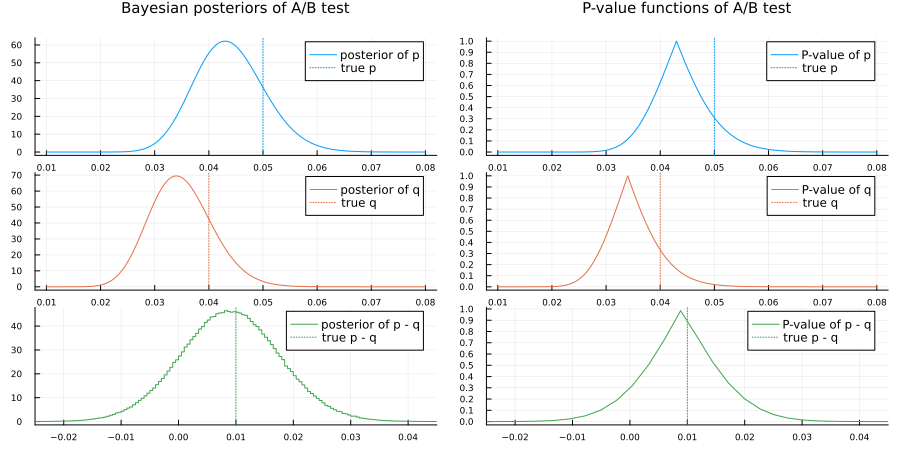

In [5]:
plot(P_bayes, P_pvalue; size=(900, 450))
plot!(topmargin=-4Plots.mm)